#YOLOv3

##1.Установка и настройка
Скачайте и настройте репозиторий YOLOv3:

In [ ]:
!git clone https://github.com/pjreddie/darknet
%cd darknet
!make


Cloning into 'darknet'...
remote: Enumerating objects: 5955, done.
remote: Total 5955 (delta 0), reused 0 (delta 0), pack-reused 5955
Receiving objects: 100% (5955/5955), 6.37 MiB | 13.21 MiB/s, done.
Resolving deltas: 100% (3931/3931), done.
/content/darknet
mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/gemm.c -o obj/gemm.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/utils.c -o obj/utils.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/cuda.c -o obj/cuda.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/convolutional_layer.c -o obj/convolutional_layer.

##2.Скачивание весов модели
Скачайте предобученные веса модели:

In [ ]:
# Скачивание весов YOLOv3
!wget https://pjreddie.com/media/files/yolov3.weights

!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names


--2024-06-04 23:10:10--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  5.43MB/s    in 2m 0s   

2024-06-04 23:12:12 (1.97 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-06-04 23:12:12--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2

##3. Запуск детекции на изображении
Используйте следующую команду для выполнения детекции объектов на изображении:

In [ ]:
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/dog.jpg
!./darknet detect cfg/yolov3.cfg yolov3.weights data/dog.jpg



--2024-06-04 23:13:41--  https://raw.githubusercontent.com/pjreddie/darknet/master/data/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163759 (160K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 159.92K  --.-KB/s    in 0.03s   

2024-06-04 23:13:41 (4.61 MB/s) - ‘dog.jpg’ saved [163759/163759]

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1          

##4.Пример кода на Python для запуска YOLOv3

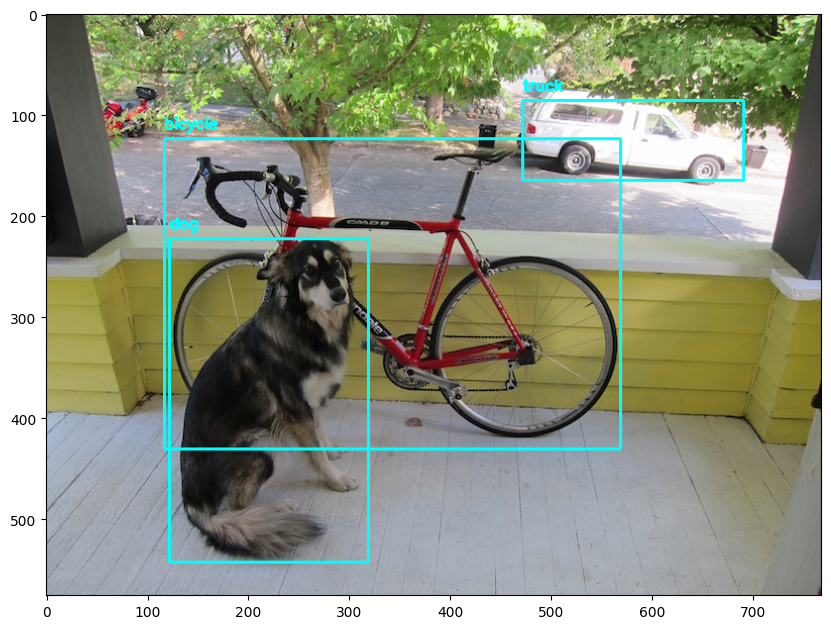

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Загрузка модели
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Загрузка изображения
img = cv2.imread("dog.jpg")
height, width, channels = img.shape

# Подготовка изображения
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

# Обработка выходов сети
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)


# Наложение результатов на изображение
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = (255, 255, 0)
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


#ResNet
##1.Установка и настройка

Установите необходимые библиотеки:

In [ ]:
# Установка PyTorch и torchvision
!pip install torch torchvision


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

##2.Пример кода на Python для запуска ResNet на CIFAR-10

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

# Загрузка и подготовка данных CIFAR-10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

# Определение модели ResNet
import torchvision.models as models
net = models.resnet18(pretrained=False, num_classes=10)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Обучение модели
for epoch in range(10):  # количество эпох
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 199:  # каждые 200 мини-батчей
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

# Тестирование модели
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

100%|██████████| 170498071/170498071 [00:03<00:00, 46101490.42it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[1, 200] loss: 2.362
[2, 200] loss: 1.379
[3, 200] loss: 1.092
[4, 200] loss: 0.925
[5, 200] loss: 0.813
[6, 200] loss: 0.729
[7, 200] loss: 0.675
[8, 200] loss: 0.624
[9, 200] loss: 0.592
[10, 200] loss: 0.556
Finished Training
Accuracy of the network on the 10000 test images: 72.04 %
